In [1]:
from ipywidgets import interact, widgets
%run -i ../helpers.py
%matplotlib inline

[nltk_data] Downloading package punkt to /Users/z.askary/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
/Users/z.askary/Desktop/Thesis/2. Model/Codes/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
Device set to use mps:0
Device set to use mps:0


In [2]:
# Set the directory path containing the CSV files
dir = './tickers/'

# Initialize an empty list to store DataFrames
frames = []

# Iterate through all files in the specified directory
for files in os.listdir(dir):
    # Check if the file has a .csv extension
    if re.search('\.csv', files):
        print(files)
        # Read the CSV file into a DataFrame
        df = pd.read_csv(dir + '/' + files, index_col=False)
        # Append the DataFrame to the list
        frames.append(df)

# Concatenate all DataFrames in the list into a single DataFrame
final_df = pd.concat(frames)

# Print the number of unique tickers in the final DataFrame
print(final_df.ticker.nunique())

final_df.drop(columns=['prep_remarks_processed','QnA_processed'], inplace=True)

# Display the first two rows of the final DataFrame
final_df.head(2)

ISRG.csv
DVN.csv
BA.csv
EQIX.csv
PODD.csv
MDT.csv
QRVO.csv
A.csv
MO.csv
SWKS.csv
ENPH.csv
CDNS.csv
MSCI.csv
WBA.csv
LVS.csv
HCA.csv
AJG.csv
C.csv
T.csv
CF.csv
APH.csv
SYY.csv
MSI.csv
ADM.csv
BAC.csv
HUBB.csv
PPG.csv
IRM.csv
IQV.csv
ESS.csv
HAL.csv
STZ.csv
BG.csv
PARA.csv
F.csv
ULTA.csv
SYK.csv
CB.csv
GNRC.csv
NOW.csv
LLY.csv
COST.csv
LOW.csv
MDLZ.csv
ZBRA.csv
FTV.csv
DLR.csv
ACGL.csv
MPC.csv
D.csv
STX.csv
NOC.csv
IPG.csv
ALLE.csv
ORCL.csv
ECL.csv
EBAY.csv
IR.csv
AMT.csv
INTU.csv
DPZ.csv
MCD.csv
MNST.csv
AMZN.csv
INTC.csv
KMI.csv
CSGP.csv
DXCM.csv
GM.csv
TXN.csv
VRSK.csv
SJM.csv
MMM.csv
HSY.csv
DHI.csv
ADSK.csv
GL.csv
KO.csv
NEE.csv
UPS.csv
UBER.csv
IT.csv
VRSN.csv
EW.csv
CMG.csv
AWK.csv
COO.csv
SHW.csv
HPQ.csv
AMAT.csv
CCL.csv
SPG.csv
AMD.csv
NDAQ.csv
URI.csv
RTX.csv
NXPI.csv
PNC.csv
KMX.csv
MTCH.csv
BIIB.csv
NVDA.csv
IDXX.csv
HD.csv
VLO.csv
AON.csv
DG.csv
INCY.csv
AXP.csv
DFS.csv
SO.csv
CVX.csv
PCG.csv
ICE.csv
BKR.csv
SBAC.csv
PTC.csv
NKE.csv
FANG.csv
RF.csv
KR.csv
PLD.csv
IBM.csv
USB

,Environmental_QnA,Environmental_prep_remarks,Governance_QnA,Governance_prep_remarks,Industry,QnA,Sector,Shortname,Social_QnA,Social_prep_remarks,dt,prep_remarks,q,ticker
0,1.0,NaN,NaN,NaN,Medical Instruments & Supplies,":\noperator\n[operator instructions] first, we...",Healthcare,"Intuitive Surgical, Inc.",1.0,0.9989,2021-01-21 16:30:00,prepared remarks:\noperator\nladies and gentle...,2020-Q4,ISRG
1,NaN,NaN,NaN,NaN,Medical Instruments & Supplies,:\noperator\n[operator instructions] and for o...,Healthcare,"Intuitive Surgical, Inc.",1.0,1.0000,2021-07-20 16:30:00,prepared remarks:\noperator\nladies and gentle...,2021-Q2,ISRG


In [3]:
# S&P 500 DataFrame
snp = pd.read_csv('../data/sp500_companies.csv')

# Convert the Symbol column in the S&P 500 DataFrame to string type
snp.Symbol = snp.Symbol.astype(str)

print("we have 465 companies from S&P 500 for which we have transcripts.")

# Print the number of unique symbols in the S&P 500 DataFrame
print(f"out of 465 companies we have so far run our model for {snp[snp.Symbol.isin(final_df.ticker.unique())].Symbol.nunique()} companies")

we have 465 companies from S&P 500 for which we have transcripts.
out of 465 companies we have so far run our model for 227 companies


In [4]:
id_cols = ['ticker', 'q', 'Name', 'Country', 'Sector','Industry']

cols_expect = ['Environmental','Social','Governance']
esg_labels = ['Environmental','Social','Governance']

final_df.rename(columns={'Shortname':'Name'}, inplace=True)

## Contradiction Analysis

In [5]:
# Define a function to calculate the difference in ESG scores between QnA and prepared remarks
def check_diff_esg_cols(df):
    retdf = []  # Initialize an empty list to store results
    for c in cols_expect:  # Iterate over the expected ESG columns
        # diff = np.nansum((df[c+'_QnA']-df[c+'_prep_remarks']))*100/df.shape[0]  # Calculate percentage difference
        diff = np.nansum((df[c+'_prep_remarks']-df[c+'_QnA']))*100/df.shape[0]  # Calculate percentage difference
        retdf.append([df.ticker.iloc[0], df.Name.iloc[0], df.Sector.iloc[0], df.Industry.iloc[0], diff, c])  # Append results
    df = pd.DataFrame(retdf, columns=['ticker', 'Name', 'Sector', 'Industry', 'pdiff', 'label'])  # Create a DataFrame
    return(df)  # Return the DataFrame

# Group the final DataFrame by ticker and apply the function to calculate differences
pdiffdf = final_df.groupby(['ticker']).apply(check_diff_esg_cols).droplevel(0)

# Filter candidates with absolute percentage differences greater than 50
gw_candidates = pdiffdf[(abs(pdiffdf.pdiff) > 50)]

# Drop the 'level_1' column if it exists in the filtered DataFrame
if 'level_1' in gw_candidates.columns:
    gw_candidates.drop(columns='level_1', inplace=True)

# Define a function to extract ESG-related text examples from a single transcript
def get_text_example_section_sing_tr(tr, neg=True, label='Environmental', sent_thresh=0.7):
    # If neg is True, filter for negative sentiment ESG-related text
    if neg:
        label_scores_df = get_esg_label_transcript(tr)  # Extract ESG label scores from the transcript
        label_scores_df['sentiment'] = label_scores_df.sent.apply(lambda x: create_sentiment_output(sentiment_pipeline(x)))  # Generate sentiment scores
        label_scores_df.sentiment = label_scores_df.sentiment.apply(lambda x: np.round(x, 4))  # Round sentiment scores to 4 decimal places
        clean_scores = label_scores_df[(label_scores_df.label_score > sent_thresh) & (label_scores_df.sentiment != 0)]  # Filter rows based on threshold and non-zero sentiment
        reslist = clean_scores[(clean_scores.sentiment < 0) & (clean_scores.esg_label == label)].sent.tolist()  # Extract negative sentiment text for the specified ESG label
        return list(set(reslist))  # Return unique negative sentiment text examples
    else:
        # If neg is False, filter for positive sentiment ESG-related text
        label_scores_df = get_esg_label_transcript(tr)  # Extract ESG label scores from the transcript
        label_scores_df['sentiment'] = label_scores_df.sent.apply(lambda x: create_sentiment_output(sentiment_pipeline(x)))  # Generate sentiment scores
        label_scores_df.sentiment = label_scores_df.sentiment.apply(lambda x: np.round(x, 4))  # Round sentiment scores to 4 decimal places
        clean_scores = label_scores_df[(label_scores_df.label_score > sent_thresh) & (label_scores_df.sentiment != 0)]  # Filter rows based on threshold and non-zero sentiment
        reslist = clean_scores[(clean_scores.sentiment > 0) & (clean_scores.esg_label == label)].sent.tolist()  # Extract positive sentiment text for the specified ESG label
        return list(set(reslist))  # Return unique positive sentiment text examples

# Define a function to extract ESG-related text examples for a specific ticker and section
# def get_text_example_for_tic_section(df, neg=True, label='Environmental', section='QnA', sent_thresh=0.7):
def get_text_example_for_tic_section(df_single_ticker, neg=True, section='QnA', sent_thresh=0.7):
    # res = []  # Initialize an empty list to store results
    res_environmental = []  # Initialize an empty list for Environmental text examples
    res_social = []  # Initialize an empty list for Social text examples
    res_governance = []  # Initialize an empty list for Governance text examples
    
    singtestdf = df_single_ticker.sort_values('q').tail(1)  # Filter the final DataFrame for a specific ticker and sort by 'q' column and take the last entry

    # Iterate through each ESG label
    for label in esg_labels:
        if label == 'Environmental':
            tr_sents = singtestdf[section].apply(get_text_example_section_sing_tr, args=(neg, label, sent_thresh))  # Apply the single transcript function to each QnA entry
            # print(len(tr_sents))
            if len(tr_sents) > 0:
                for x in tr_sents:  # Iterate through the results
                    for l in x:  # Iterate through each text example
                        if l not in res_environmental:
                            res_environmental.append(l)
        elif label == 'Social':
            tr_sents = singtestdf[section].apply(get_text_example_section_sing_tr, args=(neg, label, sent_thresh))
            if len(tr_sents) > 0:
                for x in tr_sents:  # Iterate through the results
                    for l in x:  # Iterate through each text example
                        if l not in res_social:
                            res_social.append(l)
        elif label == 'Governance':   
            tr_sents = singtestdf[section].apply(get_text_example_section_sing_tr, args=(neg, label, sent_thresh))
            # print(len(tr_sents))
            if len(tr_sents) > 0:
                for x in tr_sents:
                    for l in x:
                        if l not in res_governance:
                            res_governance.append(l)

    return res_environmental, res_social, res_governance  # Return the lists of ESG-related text examples  
    # for label in esg_labels:
    #     tr_sents = df.QnA.apply(get_text_example_section_sing_tr, args=(neg, label, section, sent_thresh))  # Apply the single transcript function to each QnA entry
    #     for x in tr_sents:  # Iterate through the results
    #         for l in x:  # Iterate through each text example
    #             if l not in res:
    #                 res.append(l)  # Append the text example to the results list
    # return res  # Return the list of ESG-related text examples

In [6]:
# Sort the DataFrame by 'pdiff' column in descending order based on absolute values
gw_candidates = gw_candidates.sort_values('pdiff', ascending=False, key=abs)

gw_candidates_list = gw_candidates.ticker.unique().tolist()  # Get unique tickers from the filtered DataFrame
print('Number of candidates:', len(gw_candidates))
gw_candidates.head()

Number of candidates: 28


,ticker,Name,Sector,Industry,pdiff,label
1,DIS,Walt Disney Company (The),Communication Services,Entertainment,132.682237,Social
0,CF,"CF Industries Holdings, Inc.",Basic Materials,Agricultural Inputs,119.292667,Environmental
1,DOV,Dover Corporation,Industrials,Specialty Industrial Machinery,117.750000,Social
0,MKC,"McCormick & Company, Incorporat",Consumer Defensive,Packaged Foods,113.620556,Environmental
0,PM,Philip Morris International Inc,Consumer Defensive,Tobacco,108.820833,Environmental


In [7]:
# print(singtestdf.shape)
# get_text_example_section_sing_tr(singtestdf.iloc[0].QnA, neg=True, label='Environmental') 
# get_text_example_section_sing_tr(singtestdf.iloc[0].prep_remarks, neg=False, label='Environmental') 

## New Plots

<Axes: title={'center': 'Number of greenwashing companies per quarter'}, xlabel='q'>

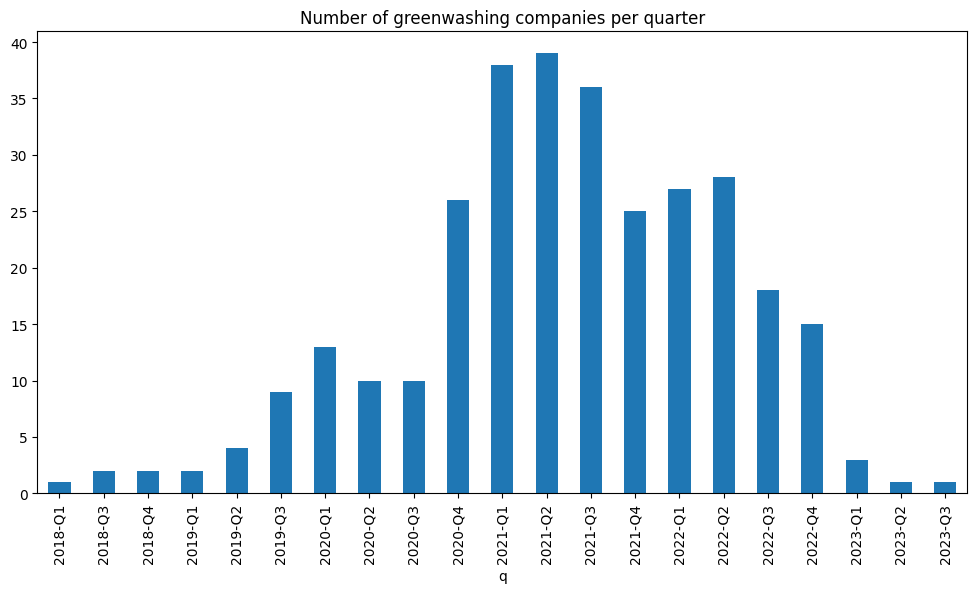

In [8]:
# - A graph with the number of greenwashing companies per quarter. Just horizontally the quarters and vertically actual number of companies greenwashing
diffdf_time = final_df.groupby(['ticker','q']).apply(check_diff_esg_cols).droplevel(0)

diffdf_time.reset_index(inplace=True)  # Reset the index of the DataFrame

diffdf_time[(abs(diffdf_time.pdiff) > 50)].groupby('q').ticker.nunique().plot(kind='bar', figsize=(12, 6), title='Number of greenwashing companies per quarter')


<Axes: title={'center': 'Top 10 industries by median greenwashing percentage'}, ylabel='Industry'>

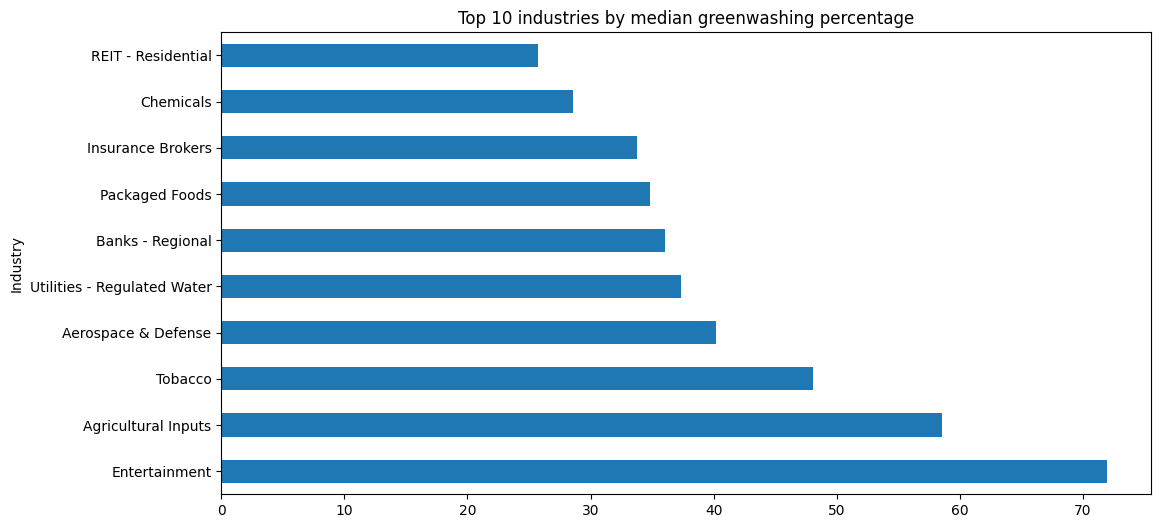

In [9]:
# - Top 10 (or just a total ranking) of the industries using greenwashing in their transcripts. 
# Like vertically all industries and horizontally how much they greenwash (median's should be fine too)
gw_candidates['greenwashing_pct'] = gw_candidates.pdiff-min(gw_candidates.pdiff)/ (max(gw_candidates.pdiff)-min(gw_candidates.pdiff)) * 100  # Calculate greenwashing percentage
gw_candidates.groupby('Industry').greenwashing_pct.median().sort_values(ascending=False).head(10).plot(kind='barh', figsize=(12, 6), title='Top 10 industries by median greenwashing percentage')

ticker
MKC     7
MNST    6
RTX     6
BALL    6
PLD     6
KMI     5
CF      5
AVB     5
CPT     5
PPG     5
Name: q, dtype: int64

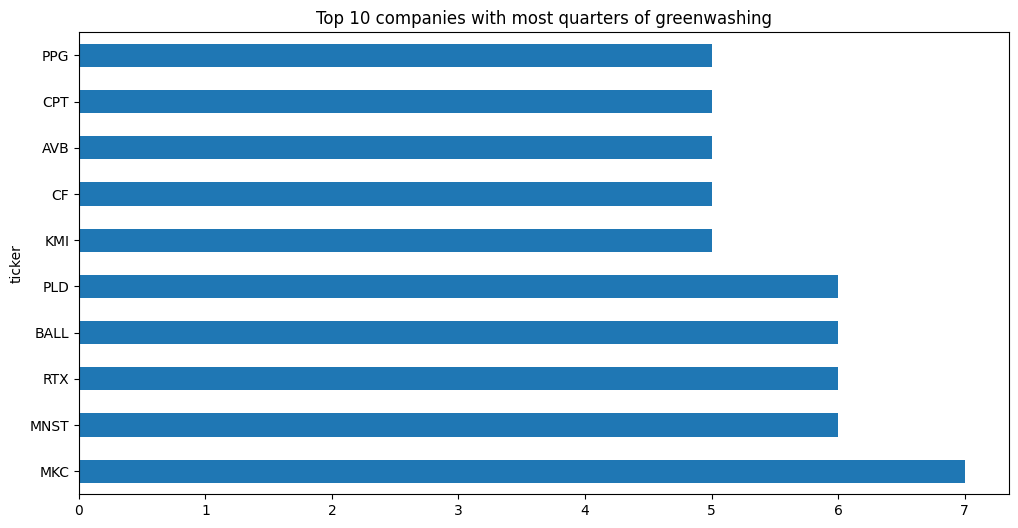

In [10]:
# - A list of companies that repeatedly greenwash over time and we found them multiple times in different quarters
diffdf_time[(abs(diffdf_time.pdiff) > 50)].groupby('ticker')['q'].nunique().sort_values(ascending=False).head(10).plot(kind='barh', figsize=(12, 6), title='Top 10 companies with most quarters of greenwashing')
diffdf_time[(abs(diffdf_time.pdiff) > 50)].groupby('ticker')['q'].nunique().sort_values(ascending=False).head(10)

In [11]:
# - A list of 20 complete sentences where an executive is talking about the environment, including quarter, company name and whether there is contradiction detected.

quarters_list = ['2019-Q2', '2019-Q3', '2020-Q1']
for q in quarters_list:
    single_df = final_df[((final_df.ticker=='CF') & (final_df.q==q))].drop_duplicates().iloc[0]

    neg_qna = get_text_example_section_sing_tr(single_df.QnA, neg=True, label='Environmental')
    pos_prepr = get_text_example_section_sing_tr(single_df.prep_remarks, neg=False, label='Environmental')

    print(f"Negative QnA examples for {single_df.ticker} in {single_df.q}:")
    for i, ex in enumerate(neg_qna[:20]):
        print(f"{i+1}. {ex}")

    print(f"\nPositive Prepared Remarks examples for {single_df.ticker} in {single_df.q}:")
    for i, ex in enumerate(pos_prepr[:20]):
        print(f"{i+1}. {ex}")

Negative QnA examples for CF in 2019-Q2:
1. but on the other hand, chinese production is supposed to be declining for environmental reasons and so forth.
2. i was just in canada last week and then driving to michigan and ohio and did some walks and runs as i go through four cornfields and i was shocked at what i saw was knee high to waist high and fields in need of nitrogen and not that many heat degree days left.
3. it was a little bit more prolonged, but we've had river issues in the past.
4. you certainly could go through a methanol cycle that reverses course in that time horizon.
5. and second, what do you think the risk and outlook is for places like iran or trinidad to sanction urea just to find the least bad version to get rid of the -- no to export their methane?
6. and when it became apparent to us that ammonia season would be challenged.

Positive Prepared Remarks examples for CF in 2019-Q2:
1. we set an all-time record for ammonia production.
2. this was critical to our abil

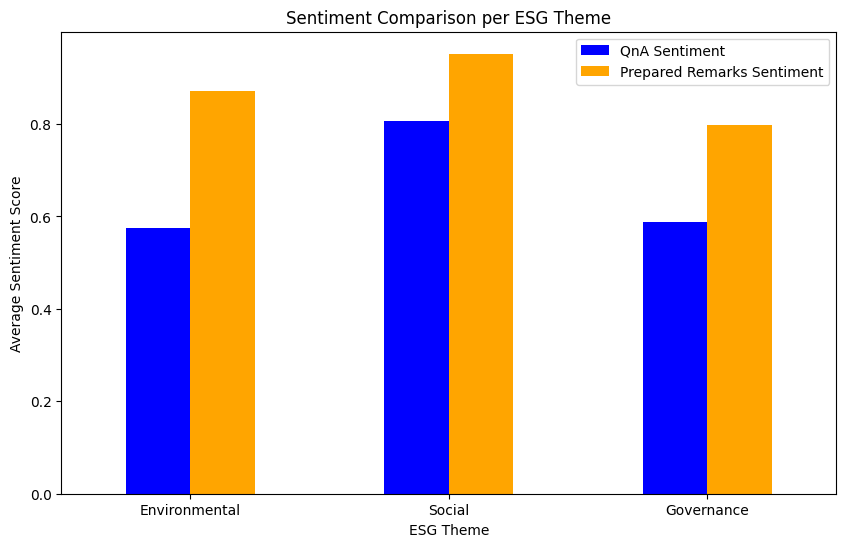

In [13]:
# - A sentiment comparison chart: like horizontally the three ESG themes and vertically the average sentiment scores, then two bars per theme indicating the sentiment for prepared remarks and Q&A
themes = ['Environmental', 'Social', 'Governance']  # Define the ESG themes
new_df_l = []
# pd.DataFrame(columns=['theme', 'QnA_sentiment', 'prep_remarks_sentiment'])  # Initialize an empty DataFrame to store sentiment scores
for theme in themes:  # Iterate through each ESG theme
    qna_sent = final_df[theme+'_QnA'].mean()  # Calculate the mean sentiment score for QnA section
    prep_sent = final_df[theme+'_prep_remarks'].mean()  # Calculate the mean sentiment score for Prepared Remarks section
    new_df_l.append({'theme': theme, 'QnA_sentiment': qna_sent, 'prep_remarks_sentiment': prep_sent}) 

new_df = pd.DataFrame(new_df_l, columns=['theme', 'QnA_sentiment', 'prep_remarks_sentiment'])  # Create a DataFrame from the list of dictionaries
# Create a grouped bar plot for sentiment comparison
new_df.plot(x='theme', kind='bar', figsize=(10, 6), title='Sentiment Comparison per ESG Theme', 
            ylabel='Average Sentiment Score', xlabel='ESG Theme', 
            color=['blue', 'orange'], legend=True)
plt.xticks(rotation=0)
plt.legend(['QnA Sentiment', 'Prepared Remarks Sentiment'])
plt.show()

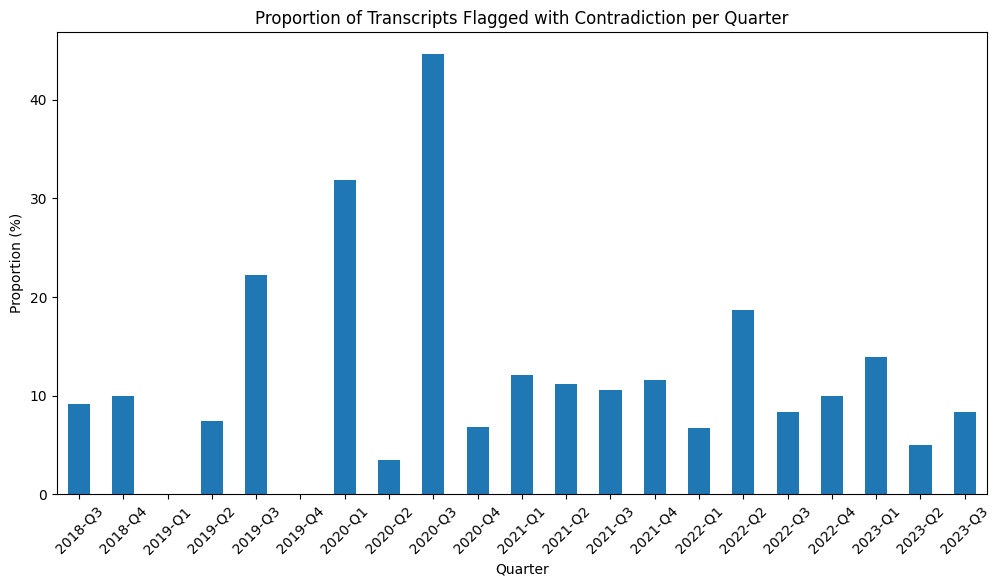

In [14]:
# - proportion of transcripts flagged with contradiction per year or quarter
new_df_prop = final_df.copy()  # Create a copy of the final DataFrame
new_df_prop['Flag_contradiction'] = new_df_prop.apply(lambda x: 1 if (x['Environmental_QnA'] < 0 and x['Environmental_prep_remarks'] > 0) or
                                                (x['Social_QnA'] < 0 and x['Social_prep_remarks'] > 0) or
                                                (x['Governance_QnA'] < 0 and x['Governance_prep_remarks'] > 0) else 0, axis=1)

quarters_with_few_transcripts = new_df_prop.q.value_counts()[final_df.q.value_counts() < 10].index.tolist()  # Identify quarters with fewer than 10 transcripts
new_df_prop = new_df_prop[~new_df_prop.q.isin(quarters_with_few_transcripts)]  # Filter out those quarters from the DataFrame
contradiction_counts = new_df_prop.groupby('q')['Flag_contradiction'].sum()  # Count contradictions per quarter
total_counts = new_df_prop.groupby('q').size()  # Count total transcripts per quarter
proportion_contradictions = (contradiction_counts / total_counts) * 100  # Calculate the proportion of contradictions
proportion_contradictions.plot(kind='bar', figsize=(12, 6), title='Proportion of Transcripts Flagged with Contradiction per Quarter', ylabel='Proportion (%)', xlabel='Quarter')
plt.xticks(rotation=45)
plt.show()

In [15]:
# - total % of contradiction found per ESG theme
for theme in esg_labels:
    contradiction_count = new_df_prop[(new_df_prop[theme+'_QnA'] < 0) & (new_df_prop[theme+'_prep_remarks'] > 0)].shape[0]  # Count contradictions for the theme
    total_count = new_df_prop.shape[0]  # Total number of transcripts
    proportion = (contradiction_count / total_count) * 100 if total_count > 0 else 0  # Calculate proportion
    print(f"Total % of contradiction found for {theme}: {proportion:.2f}%")  # Print the result

Total % of contradiction found for Environmental: 5.43%
Total % of contradiction found for Social: 7.16%
Total % of contradiction found for Governance: 0.10%


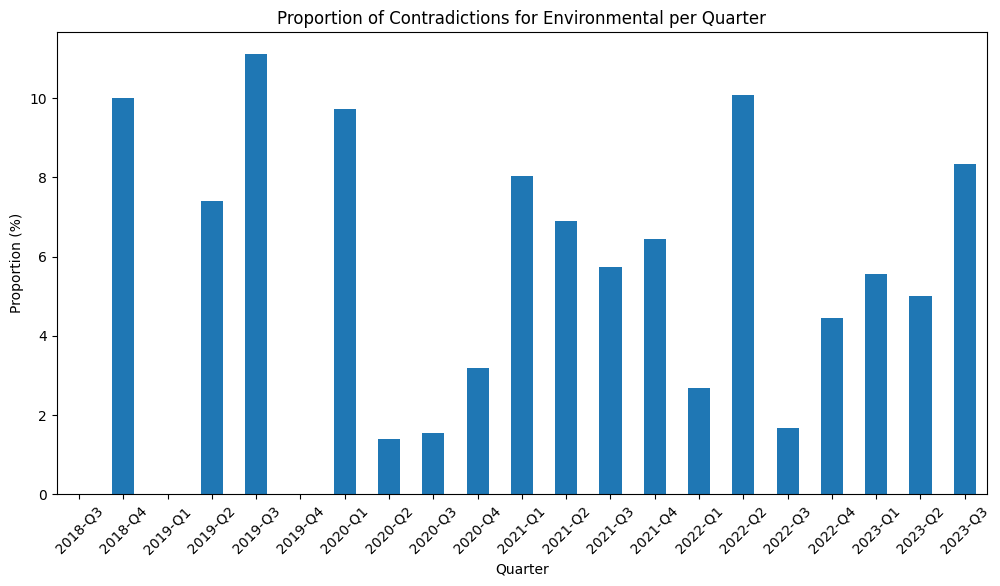

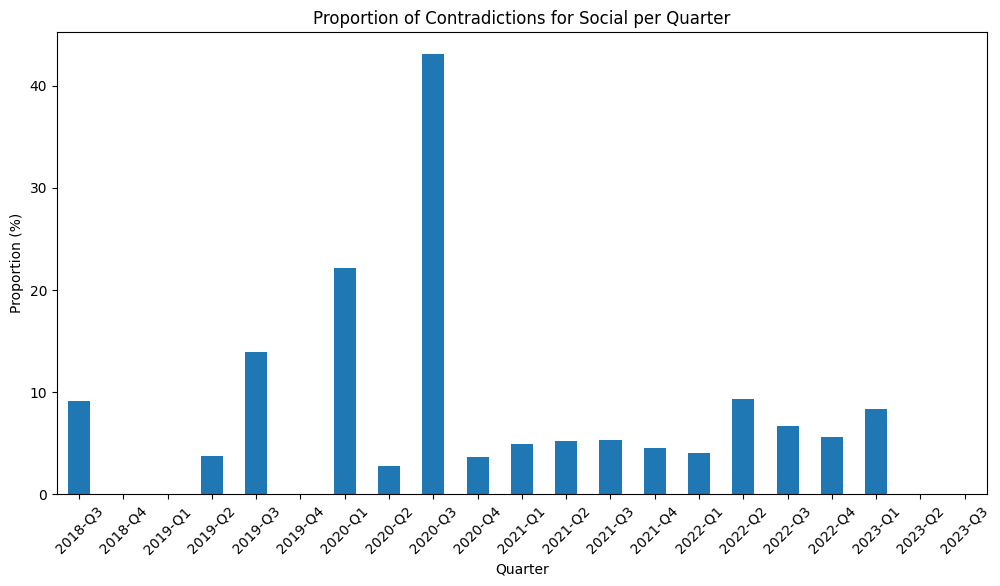

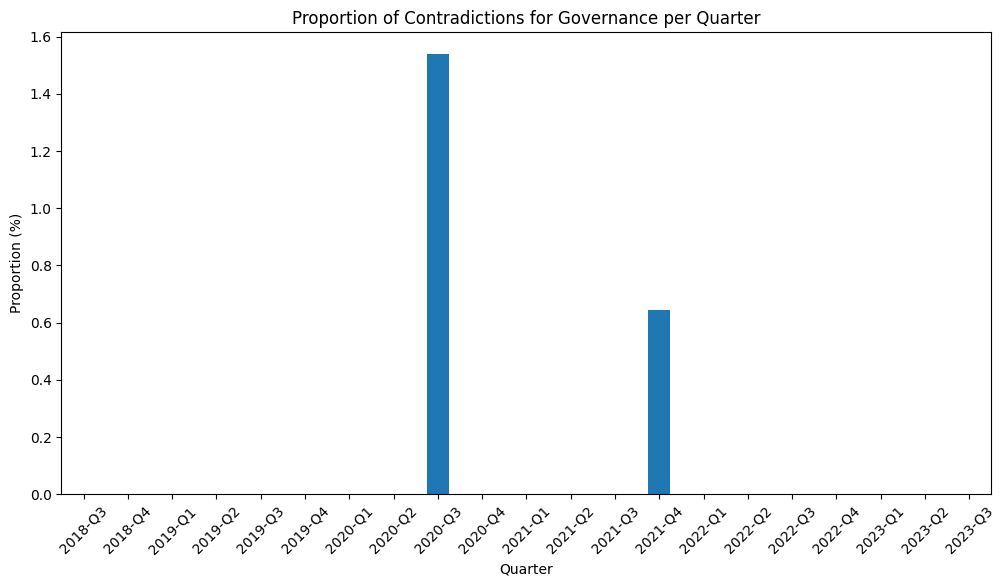

In [16]:
# - total % of contradictions per ESG theme in a timeline evolution per year or quarter
for theme in esg_labels:
    contradiction_counts = new_df_prop[(new_df_prop[theme+'_QnA'] < 0) & (new_df_prop[theme+'_prep_remarks'] > 0)].groupby('q').size()  # Count contradictions per quarter
    total_counts = new_df_prop.groupby('q').size()  # Count total transcripts per quarter
    proportion_contradictions = (contradiction_counts / total_counts) * 100  # Calculate the proportion of contradictions
    proportion_contradictions.plot(kind='bar', figsize=(12, 6), title=f'Proportion of Contradictions for {theme} per Quarter', ylabel='Proportion (%)', xlabel='Quarter')
    plt.xticks(rotation=45)
    plt.show()

## Interactive App

In [27]:
# label=widgets.Dropdown(options=esg_labels, value='Social')
# Decorator to create an interactive widget for the function
@interact
def func(company_tic=widgets.Dropdown(options=gw_candidates.ticker.tolist(), value='CF'),):
    # Print blank lines for spacing
    print('\n'*2)
    # Display the selected ESG label and greenwashing candidates
    print(f'Some Greenwashing candidates')
    # Display the top 50 greenwashing candidates sorted by absolute percentage difference
    # display(gw_candidates[gw_candidates.label == label].sort_values('pdiff', ascending=False, key=abs).head(50))
    display(gw_candidates.sort_values('pdiff', ascending=False, key=abs).head(10))
    # Filter the final DataFrame for the selected company and negative ESG scores in QnA
    chosen_candidate_df = final_df[(final_df.ticker == company_tic)].drop_duplicates()

    # Print blank lines for spacing
    print('\n')
    # Display the ESG scores for the selected company
    print(f'\n Scores for {company_tic}:')
    
    # Create a plot for the ESG scores
    # fig, ax = plt.subplots(figsize=(8, 5))
    # Filter and sort the DataFrame for the selected company
    tdf = final_df[final_df.ticker == company_tic].drop_duplicates().sort_values('q')
    
    # Select all labels
    esg_labels = ['Environmental', 'Social', 'Governance']

    for label in esg_labels:
        # Check if the ESG label scores for QnA and prepared remarks are not null
        if(tdf[label+'_QnA'].notnull().any() and tdf[label+'_prep_remarks'].notnull().any()):
            fig, ax = plt.subplots(figsize=(20, 10))  # Create a figure and axis for the plot
            plt.plot(tdf.q, tdf[label+'_QnA'], label=label + '_QnA')  # Plot the ESG label scores for QnA
            plt.plot(tdf.q, tdf[label+'_prep_remarks'], label=label + '_prep_remarks')
            plt.title(f"Prepared Remarks vs QnA Scores for {label}")
            plt.legend()  # Add a legend to the plot
            plt.show()  # Display the plot

    # Print blank lines for spacing
    print('\n')
    # Display widgets for risks and optimism in prepared remarks
    # display(widgets.Text(value='Risks/ Conflicting statements from QnA sections', placeholder='Risks'))
    # display(widgets.Text(value='Optimism in prepared remarks', placeholder='Risks'))
    # Get negative sentiment ESG-related text examples from QnA sections
    # sent_eg = get_text_example_for_tic_section(chosen_candidate_df, True, label, section='QnA', sent_thresh=0.7)

    print('Quarter for the example:', chosen_candidate_df.sort_values('q').q.tail(1).iloc[0])  # Print the quarter of the filtered DataFrame

    sent_eg_environmental_neg, sent_eg_social_neg, sent_eg_governance_neg = get_text_example_for_tic_section(chosen_candidate_df, True, section='QnA', sent_thresh=0.7)
    sent_eg_environmental_pos, sent_eg_social_pos, sent_eg_governance_pos = get_text_example_for_tic_section(chosen_candidate_df, False, section='prep_remarks', sent_thresh=0.7)

    for label in esg_labels:
        if label == 'Environmental':
            if(len(sent_eg_environmental_neg) > 0 or len(sent_eg_environmental_pos) > 0):
                if(len(sent_eg_environmental_neg) > 0):
                    print(f'Environmental text examples for QnA: {sent_eg_environmental_neg}')
                    display(widgets.Textarea(value='Environmental  examples for QnA: \n'+'\n'.join(sent_eg_environmental_neg)))
                if(len(sent_eg_environmental_pos) > 0):
                    print(f'Environmental text examples for Prepared Remarks: {sent_eg_environmental_pos}')
                    display(widgets.Textarea(value='Environmental text examples for Prepared Remarks: \n'+'\n'.join(sent_eg_environmental_pos)))
        elif label == 'Social':
            if(len(sent_eg_social_neg) > 0 or len(sent_eg_social_pos) > 0):
                if(len(sent_eg_social_neg) > 0):
                    print(f'Social text examples for QnA: {sent_eg_social_neg}')
                    display(widgets.Textarea(value='Social text examples for QnA: '+'\n'.join(sent_eg_social_neg)))
                if(len(sent_eg_social_pos) > 0):
                    print(f'Social text examples for Prepared Remarks: {sent_eg_social_pos}')
                    display(widgets.Textarea(value='Social text examples for Prepared Remarks: '+'\n'.join(sent_eg_social_pos)))
        elif label == 'Governance':
            if(len(sent_eg_governance_neg) > 0 or len(sent_eg_governance_pos) > 0):
                if(len(sent_eg_governance_neg) > 0):
                    print(f'Governance text examples for QnA: {sent_eg_governance_neg}')
                    display(widgets.Textarea(value='Governance text examples for QnA: '+'\n'.join(sent_eg_governance_neg)))
                if(len(sent_eg_governance_pos) > 0):
                    print(f'Governance text examples for Prepared Remarks: {sent_eg_governance_pos}')
                    display(widgets.Textarea(value='Governance text examples for Prepared Remarks: '+'\n'.join(sent_eg_governance_pos)))

        # # Define tab contents for risks and prepared remarks
        # tab_contents = ['QnA_'+label, 'Prep_remarks_'+label]
        # # Create HTML widgets for each tab
        # children = [widgets.HTML(value=f"<b>{name}", description=name) for name in tab_contents]
        # # Create a tab widget
        # tab = widgets.Tab()
        # # Assign the HTML widgets to the tab
        # tab.children = children
        # # Set titles for the tabs
        # tab.set_title(0, 'QnA_' + label)
        # tab.set_title(1, 'Prepared remarks_' + label)

    # Populate the risks tab with unique negative sentiment text examples
    # children[0].value = '<br>'.join(np.unique(sent_eg))
    # Populate the prepared remarks tab with unique positive sentiment text examples
    # children[1].value = '<br>'.join(np.unique(wordcloud_data_statements))
    # Display the tab widget
    # display(tab)

    # Print a message for the word cloud
    print('\n\n Wordcloud on the prepared remarks\n')
    wordcloud_data_statements = get_text_example_for_tic_section(chosen_candidate_df.tail(1), False, 
                                                                 section='prep_remarks', sent_thresh=0.7)
    
    # If there are positive sentiment text examples, generate a word cloud
    if len(wordcloud_data_statements) > 0:
        get_wordcloud(wordcloud_data_statements)
        plt.show()

    # Print blank lines for spacing
    print('\n'*2)
    # Display the total number of companies and those with conflicting statements
    print(f'Total # of companies: {final_df.ticker.nunique()} and we found conflicting statements in {gw_candidates.ticker.nunique()}')
    # Group greenwashing candidates by sector and count the number of companies detected
    sector_ct = gw_candidates[gw_candidates.label == label].groupby('Sector')['ticker'].nunique().reset_index()\
                                                            .rename(columns={'ticker': 'companies_detected'})
    # Group all companies by sector and count the total number of companies
    secdfall = final_df.groupby('Sector')['ticker'].nunique().reset_index().rename(columns={'ticker': 'total_num_companies'})
    # Merge the detected companies with the total companies by sector
    secdfall = secdfall.merge(sector_ct, how='left', on='Sector')

    # Plot the total number of companies and detected companies by sector
    #secdfall.plot(x='Sector', y=['total_num_companies', 'companies_detected'], kind='bar', figsize=(10, 5)).legend(bbox_to_anchor=(1, 1))

    # End the function
    return


interactive(children=(Dropdown(description='company_tic', index=1, options=('DIS', 'CF', 'DOV', 'MKC', 'PM', '…

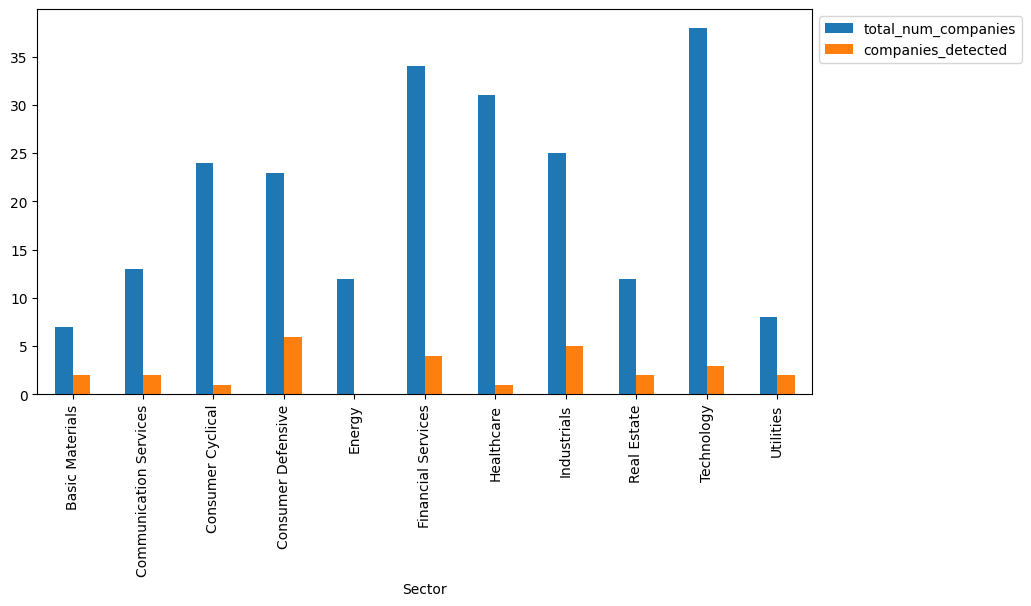

In [18]:
sector_ct = gw_candidates.groupby('Sector')['ticker'].nunique().reset_index()\
                                                            .rename(columns={'ticker': 'companies_detected'})
secdfall = final_df.groupby('Sector')['ticker'].nunique().reset_index().rename(columns={'ticker': 'total_num_companies'})
# Merge the detected companies with the total companies by sector
secdfall = secdfall.merge(sector_ct, how='left', on='Sector')

# Plot the total number of companies and detected companies by sector
secdfall.plot(x='Sector', y=['total_num_companies', 'companies_detected'], kind='bar', figsize=(10, 5)).legend(bbox_to_anchor=(1, 1))

### Annotation Data generation 
### We have two ways that we generated annotation file

## number 1

In [30]:

# # random_list_for_annotation = final_df[~final_df.ticker.isin(gw_candidates_list)].sample(10)
# random_tickers = list(np.random.choice(final_df[~final_df.ticker.isin(gw_candidates_list)].ticker.unique(),10))
# # random_tickers = ['LOW', 'TXT', 'PLTR', 'IT', 'ISRG', 'HST', 'LRCX', 'IDXX', 'GOOGL','TRV']
# random_list_for_annotation = final_df[final_df.ticker.isin(random_tickers)].sort_values('q').groupby('ticker').tail(1)

# print(random_list_for_annotation.shape)
# res_l = []

# for idx, row in random_list_for_annotation.iterrows():
#     print(row.ticker, row.Name)
#     res_env = get_text_example_section_sing_tr(row.QnA, neg=False, label='Environmental')
#     res_soc = get_text_example_section_sing_tr(row.QnA, neg=False, label='Social')
#     res_gov = get_text_example_section_sing_tr(row.QnA, neg=False, label='Governance')

#     res_prep_remarks_env = get_text_example_section_sing_tr(row.prep_remarks, neg=False, label='Environmental')
#     res_prep_remarks_soc = get_text_example_section_sing_tr(row.prep_remarks, neg=False, label='Social')    
#     res_prep_remarks_gov = get_text_example_section_sing_tr(row.prep_remarks, neg=False, label='Governance')

#     res_l.append([row.ticker, row.Name, row.Sector, row.Industry, row.q, 'QnA', res_env, '', res_soc, '', res_gov, '', 'Prepared_Remarks', res_prep_remarks_env, '', res_prep_remarks_soc, '', res_prep_remarks_gov, ''])

# gw_list_for_annotation = pd.DataFrame(res_l, columns=['ticker', 'Name', 'Sector', 'Industry', 'Quarter',
#                                                       'QnA_Section_starts', 'Environmental', 'Environmental_Positive_or_not',
#                                                       'Social', 'Social_Positive_or_not',
#                                                       'Governance', 'Governance_Positive_or_not',
#                                                       'Prepared_Remarks_Section_starts', 'Environmental', 'Environmental_Positive_or_not',
#                                                       'Social', 'Social_Positive_or_not',
#                                                       'Governance', 'Governance_Positive_or_not'])
# gw_list_for_annotation.to_excel('random_list_for_annotation_random_1.xlsx', index=False)

In [31]:
# # Create a DataFrame for annotation with greenwashing candidates
# gw_list_for_annotation = final_df[final_df.ticker.isin(gw_candidates_list)]
# # gw_list_for_annotation.groupby('ticker'))
# gw_list_for_annotation = gw_list_for_annotation.sort_values('q').groupby('ticker').tail(1)

# print(gw_list_for_annotation.shape)
# res_l = []
# for idx, row in gw_list_for_annotation.iterrows():
#     print(row.ticker, row.Name)
#     res_env = get_text_example_section_sing_tr(row.QnA, neg=True, label='Environmental')
#     res_soc = get_text_example_section_sing_tr(row.QnA, neg=True, label='Social')
#     res_gov = get_text_example_section_sing_tr(row.QnA, neg=True, label='Governance')

#     res_prep_remarks_env = get_text_example_section_sing_tr(row.prep_remarks, neg=False, label='Environmental')
#     res_prep_remarks_soc = get_text_example_section_sing_tr(row.prep_remarks, neg=False, label='Social')    
#     res_prep_remarks_gov = get_text_example_section_sing_tr(row.prep_remarks, neg=False, label='Governance')

#     res_l.append([row.ticker, row.Name, row.Sector, row.Industry, row.q, 'QnA', res_env, '', res_soc, '', res_gov, '', 'Prepared_Remarks', res_prep_remarks_env, '', res_prep_remarks_soc, '', res_prep_remarks_gov, ''])

# gw_list_for_annotation = pd.DataFrame(res_l, columns=['ticker', 'Name', 'Sector', 'Industry', 'Quarter',
#             'QnA_Section_starts', 'Environmental', 'Environmental_Negative_or_not', 
#             'Social', 'Social_Negative_or_not', 
#             'Governance', 'Governance_Negative_or_not', 
#             'Prepared_Remarks_Section_starts', 'Environmental', 'Environmental_Positive_or_not', 
#             'Social', 'Social_Positive_or_not', 
#             'Governance', 'Governance_Positive_or_not'])
# gw_list_for_annotation.to_excel('annotation_data.xlsx', index=False)  # Save the DataFrame to an Excel file


In [32]:
# gw_list_for_annotation.to_csv('annotation_data.csv', index=False)  # Save the DataFrame to a CSV file

## number 2

In [33]:

# # - A bigger export of ESG sentences with contradictions in Excel

# # TOO Time consuming to run, so we will not run it here. 
# # The results are saved in the file 'annotation_data_2nd_version.xlsx'

# # old_list = pd.read_excel('annotation_data.xlsx')  # Load the old annotation data from an Excel file
# # old_list_tickers = old_list.ticker.unique().tolist()  # Get unique tickers from the old annotation data
# # print('Number of old tickers:', len(old_list_tickers))

# gw_list_for_annotation = final_df[final_df.ticker.isin(gw_candidates_list)].drop_duplicates()
# # gw_list_for_annotation = gw_list_for_annotation.sort_values('q').groupby('ticker').tail(1)

# # gw_list_for_annotation_new = gw_list_for_annotation[~gw_list_for_annotation.ticker.isin(old_list_tickers)]  # Filter out tickers already in the old annotation data
# # print('Number of new tickers for annotation:', len(gw_list_for_annotation_new)) 

# print(gw_list_for_annotation.shape)
# res_l = []
# for ticker in gw_list_for_annotation.ticker.unique():
#     all_q = np.sort(gw_list_for_annotation[gw_list_for_annotation.ticker=='CF'].q.unique())[-3:] # Get the last three quarters for the current ticker
#     for q in all_q:    
#         for idx, row in gw_list_for_annotation[(gw_list_for_annotation.ticker==ticker) & (gw_list_for_annotation.q==q)].drop_duplicates().iterrows():
#             print(row.ticker, row.Name, row.q)
#             res_env = get_text_example_section_sing_tr(row.QnA, neg=True, label='Environmental')
#             res_soc = get_text_example_section_sing_tr(row.QnA, neg=True, label='Social')
#             res_gov = get_text_example_section_sing_tr(row.QnA, neg=True, label='Governance')

#             res_prep_remarks_env = get_text_example_section_sing_tr(row.prep_remarks, neg=False, label='Environmental')
#             res_prep_remarks_soc = get_text_example_section_sing_tr(row.prep_remarks, neg=False, label='Social')    
#             res_prep_remarks_gov = get_text_example_section_sing_tr(row.prep_remarks, neg=False, label='Governance')

#             res_l.append([row.ticker, row.Name, row.Sector, row.Industry, row.q, 'QnA', res_env, '', res_soc, '', res_gov, '', 'Prepared_Remarks', res_prep_remarks_env, '', res_prep_remarks_soc, '', res_prep_remarks_gov, ''])

# gw_list_for_annotation = pd.DataFrame(res_l, columns=['ticker', 'Name', 'Sector', 'Industry', 'Quarter',
#             'QnA_Section_starts', 'Environmental', 'Environmental_Negative_or_not', 
#             'Social', 'Social_Negative_or_not', 
#             'Governance', 'Governance_Negative_or_not', 
#             'Prepared_Remarks_Section_starts', 'Environmental', 'Environmental_Positive_or_not', 
#             'Social', 'Social_Positive_or_not', 
#             'Governance', 'Governance_Positive_or_not'])
# gw_list_for_annotation.to_excel('annotation_data_2nd_version.xlsx', index=False)  # Save the DataFrame to an Excel file
